#Flow rate waveform transformation

Arjan Geers

An artery's flow rate waveform (FRW) can be characterized in many ways. Three common descriptors are the heart rate (HR), pulsatility index (PI), and time-averaged flow rate (QTA). In this notebook, a FRW is linearly transformed to generate new FRWs with specified values for these descriptors.

In a recent study, we used FRW transformation to test how each descriptor in isolation affects the hemodynamics. This work was [published](http://dx.doi.org/10.1016/j.jbiomech.2013.09.033) in the Journal of Biomechanics:

Geers AJ, Larrabide I, Morales HG, Frangi AF. Approximating hemodynamics of cerebral aneurysms with steady flow simulations. Journal of Biomechanics, 47(1):178–185, 2014.

##Preamble

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import division
from IPython.html import widgets
from IPython.display import display

:0: FutureWarning: IPython widgets are experimental and may change in the future.


##Data

We start by reading the FRW of a healthy volunteer's internal carotid artery (ICA). This data was acquired with PC-MRA by Cebral et al. as part of [this study](http://dx.doi.org/10.1023/B:ENGI.0000007977.02652.02).

The 99 unique flow rate values (in ml/s) are uniformly distributed in time. Corresponding time values will be added during the transformation to account for the heart rate.

In [3]:
frw = pd.read_csv(os.path.join('..', 'data', 'frw.csv'))

In [4]:
pd.set_option('display.max_rows', 10)
frw

,flowrate (ml/s)
0,2.100451
1,2.613188
2,4.132279
3,6.301960
4,8.448246
...,...
94,2.621831
95,2.547649
96,2.466270
97,2.355295


The physiological ranges over which to vary the FRW descriptors are defined as follows: 

In [5]:
def qcebral(radius=2e-3):
    """Use relationship from Cebral et al. Physiol Meas, 2008,
    to return a flow rate in ml/s for a given radius in meters.
    
    """ 
    area = np.pi * radius**2
    return 48.21 * (1e4 * area)**1.84

frw_descriptors = pd.DataFrame(index=['lower',
                                      'baseline',
                                      'upper'], 
                               columns=['HR (bpm)',
                                        'PI (-)',
                                        'QTA (ml/s)'])

frw_descriptors['HR (bpm)'] = [52, 68, 84]
frw_descriptors['PI (-)'] = [0.58, 0.92, 1.26]
frw_descriptors['QTA (ml/s)'] = [0.73*qcebral(), qcebral(), 1.27*qcebral()]
frw_descriptors

,HR (bpm),PI (-),QTA (ml/s)
lower,52,0.58,0.774473
baseline,68,0.92,1.060922
upper,84,1.26,1.347370


This dataframe corresponds to Table 1 of our paper.

For HR and PI, the three values are defined as:
* baseline = mean
* lower = mean - 2 SD
* upper = mean + 2 SD

where the mean and standard deviation (SD) are taken from [Ford et al.](http://dx.doi.org/10.1088/0967-3334/26/4/013) and [Hoi et al.](http://dx.doi.org/10.1088/0967-3334/31/3/002).

Values for QTA were derived from another [paper](http://dx.doi.org/10.1088/0967-3334/29/5/005) by Cebral et al. in which they experimentally determined the relationship between the cross sectional area and time-averaged flow rate of ICAs and vertebral arteries (VAs):

Qcebral = 48.21 \* A^1.84

where A is the cross sectional area in cm^2 and Qcebral is in ml/s.

Qcebral was taken as baseline value for QTA. The lower and upper values were 27% below and above the baseline, respectively. The 27% variation is the average relative error between prediction and measurement, derived from Cebral et al.'s paper.

To get some actual values for QTA to work with, we assume an artery with a circular cross section and a radius of 2 mm, which is about the size of an ICA.

##Transformation

Following Eq. 1 of our paper, the FRW transformation from $\textrm{Q}^0(t)$ to $\textrm{Q}(t)$ is given by:

\begin{equation}
  \textrm{Q}(t) = a \, \textrm{Q}^0(c t) + b
\end{equation}

where

\begin{equation}
a = \frac{\textrm{QTA}}{\textrm{QTA}^0} \frac{\textrm{PI}}{\textrm{PI}^0},%
\qquad b = \textrm{QTA} \left(1 - \frac{\textrm{PI}}{\textrm{PI}^0}\right),%
\qquad c = \frac{\textrm{HR}}{\textrm{HR}^0}
\end{equation}

We implement this as `transform_frw`, which takes as input:
* `frw_in`, i.e. $\textrm{Q}^0(t)$
* `hr_out`, i.e. $\textrm{HR}$
* `pi_out`, i.e. $\textrm{PI}$
* `qta_out`, i.e. $\textrm{QTA}$

In [6]:
def transform_frw(frw_in, hr_out, pi_out, qta_out):
    """Linearly transform a flow rate waveform (frw_in) to generate one with
    specified heart rate (hr_out), pulsatility index (pi_out), and
    time-averaged flow rate (qta_out).
    
    The input flow rate waveform is a pandas DataFrame with a single column of
    unique flow rate values uniformly distributed in time.
    
    The output flow rate waveform is a pandas DataFrame with a time and a flow
    rate column.
    
    ----------------------------------------------------------------------------
    On calculating time-average values:
    
    Time-averaged values are calculated by numerical integration using the
    trapezoidal rule.

    T is period
    var[t] is variable as function of time
    n is number of trapezoid areas
    h = T/n is width of each trapezoid
    varta = time-averaged value of variable

    varta = 1/T * Integrate[var[t], {t, 0, T}]
          = 1/T * h * (0.5*var[t_0] + var[t_1] + ... + 0.5*var[t_n])
          = 1/n * (0.5*var[t_0] + var[t_1] + ... + 0.5*var[t_n])
          = 1/n * (var[t_0] + ... + var[t_n-1])
          = mean(var[t_0], ..., var[t_n-1])
          
    In the last step, we used the property of a periodic function that
    var[t_0] = var[t_n].
    ----------------------------------------------------------------------------
    
    """
    hr_in = 60
    qta_in = np.mean(frw_in)
    pi_in = (np.amax(frw_in) - np.amin(frw_in)) / qta_in

    qta_ratio = qta_out / qta_in
    pi_ratio = pi_out / pi_in
    hr_ratio = hr_out / hr_in
    
    a = qta_ratio * pi_ratio
    b = qta_out * (1 - pi_ratio)
    c = hr_ratio  # inverse of cardiac period 
    
    frw_out = a * frw_in + b
    
    numberoftimesteps = len(frw_out)
    t = [timestep / (c * numberoftimesteps) for timestep in range(numberoftimesteps)]
    frw_out.insert(0, 'time (s)', pd.Series(t))
    
    return frw_out

##Interactive plot

To demo how the three descriptors change the shape of the FRW, we plot the transformed FRW and provide sliders to interactively adjust the descriptor values.

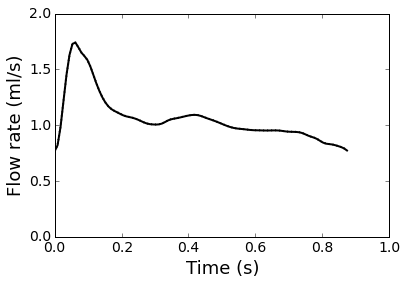

In [7]:
def plotfrw(hr_out, pi_out, q_out):
    frw_out = transform_frw(frw, hr_out, pi_out, q_out)
    frw_baseline = transform_frw(frw, *frw_descriptors.ix['baseline'].tolist())
    fig, ax = plt.subplots()
    ax.plot(frw_out['time (s)'], frw_out['flowrate (ml/s)'], c='black', lw=2, )
    ax.plot(frw_baseline['time (s)'], frw_baseline['flowrate (ml/s)'], c='black', ls=':', lw=2, )
    ax.set_xlabel('Time (s)', fontsize=18)
    ax.set_ylabel('Flow rate (ml/s)', fontsize=18)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 2)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
hr_slider = widgets.IntSlider(description='HR (bpm)',
                              value=frw_descriptors['HR (bpm)']['baseline'],
                              min=frw_descriptors['HR (bpm)']['lower'],
                              max=frw_descriptors['HR (bpm)']['upper'],
                              step=0.1)
pi_slider = widgets.FloatSlider(description='PI (-)',
                                value=frw_descriptors['PI (-)']['baseline'],
                                min=frw_descriptors['PI (-)']['lower'],
                                max=frw_descriptors['PI (-)']['upper'],
                                step=0.01)
q_slider = widgets.FloatSlider(description='QTA (ml/s)',
                               value=round(frw_descriptors['QTA (ml/s)']['baseline'], 2),
                               min=round(frw_descriptors['QTA (ml/s)']['lower'], 2),
                               max=round(frw_descriptors['QTA (ml/s)']['upper'], 2),
                               step=0.01)
w = widgets.interact(plotfrw, hr_out=hr_slider, pi_out=pi_slider, q_out=q_slider)